Loading data from C:\Users\Spacecowboy\Downloads\combined_results_all_combined.xlsx...
Loaded 178 rows
Columns: ['source', 'Method', 'Model', 'X_dist', 'n', 'n_reps', 'd_true', 'n_correct', 'dim_accuracy', 'time_mean', 'time_std', 'subspace_error_mean', 'subspace_error_std', 'minimize_time_mean', 'minimize_time_std', 'minimize_iters_mean', 'minimize_iters_std', 'time_per_iter_mean', 'time_per_iter_std', 'time_all_mean', 'time_all_std', 'subspace_error_all_mean', 'subspace_error_all_std', 'minimize_time_all_mean', 'minimize_time_all_std', 'minimize_iters_all_mean', 'minimize_iters_all_std', 'time_per_iter_all_mean', 'time_per_iter_all_std', 'p']

Filtered to 178 rows for methods: ['BS', 'NW']

Unique models: ['M1', 'M2', 'M3_func1', 'M3_func2']
Unique methods: ['BS' 'NW']
Unique X_dist: ['normal' 'uniform']
Unique n values: [np.int64(50), np.int64(100), np.int64(400), np.int64(1000), np.int64(2000), np.int64(5000)]
Unique p values: [np.int64(5), np.int64(10)]

CONFIGURATION
Analysis mod

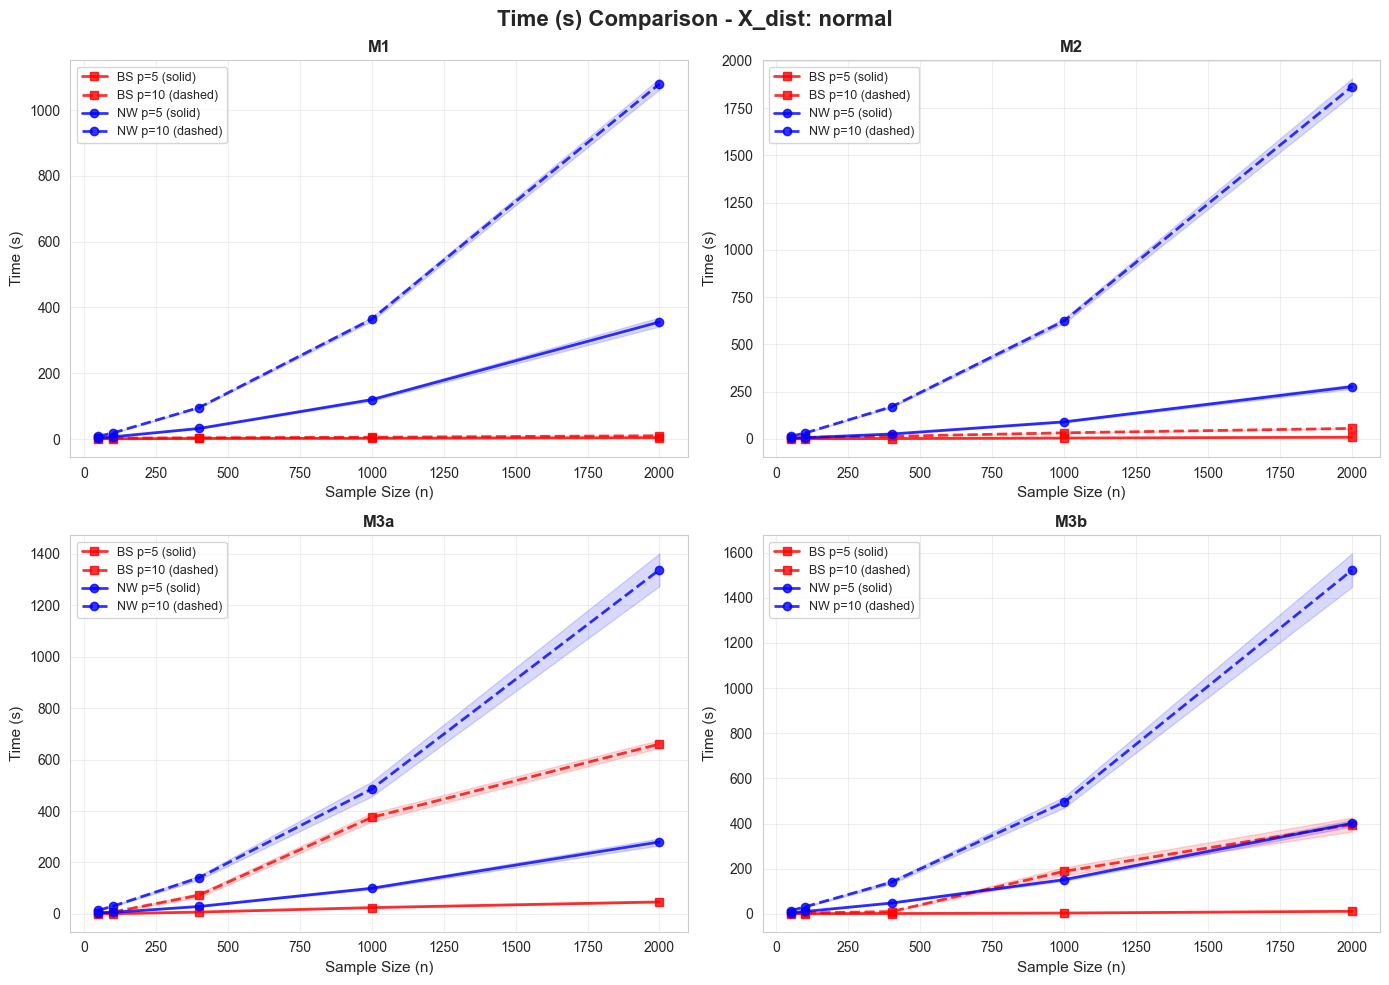

Saved: C:\Users\Spacecowboy\Downloads\time_all_comparison_uniform.png


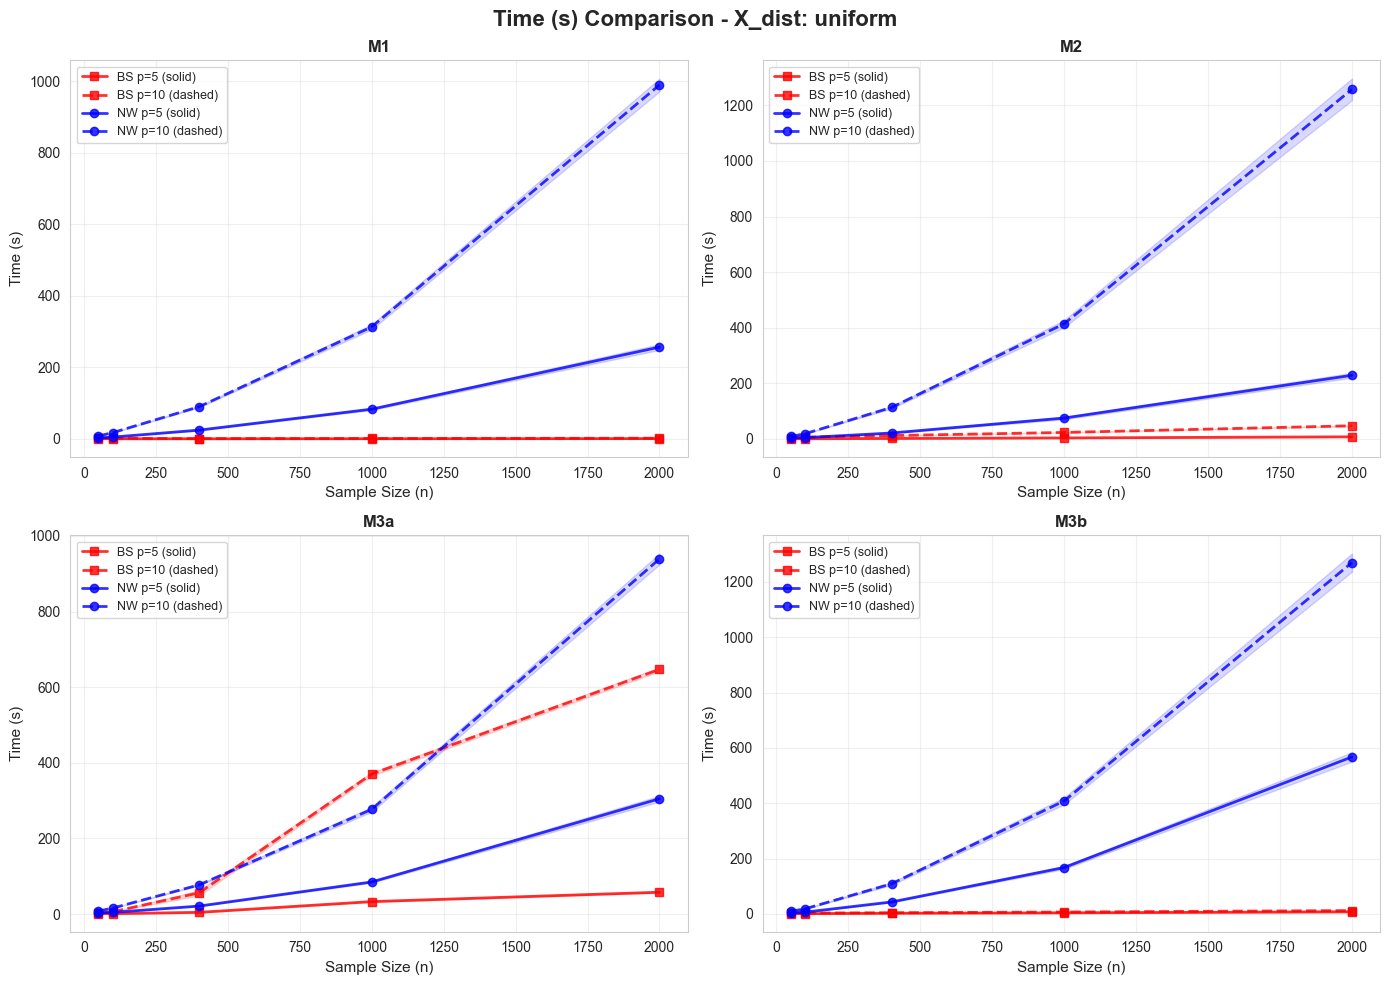


Plotting subspace_error_all_mean...
Saved: C:\Users\Spacecowboy\Downloads\subspace_error_all_comparison_normal.png


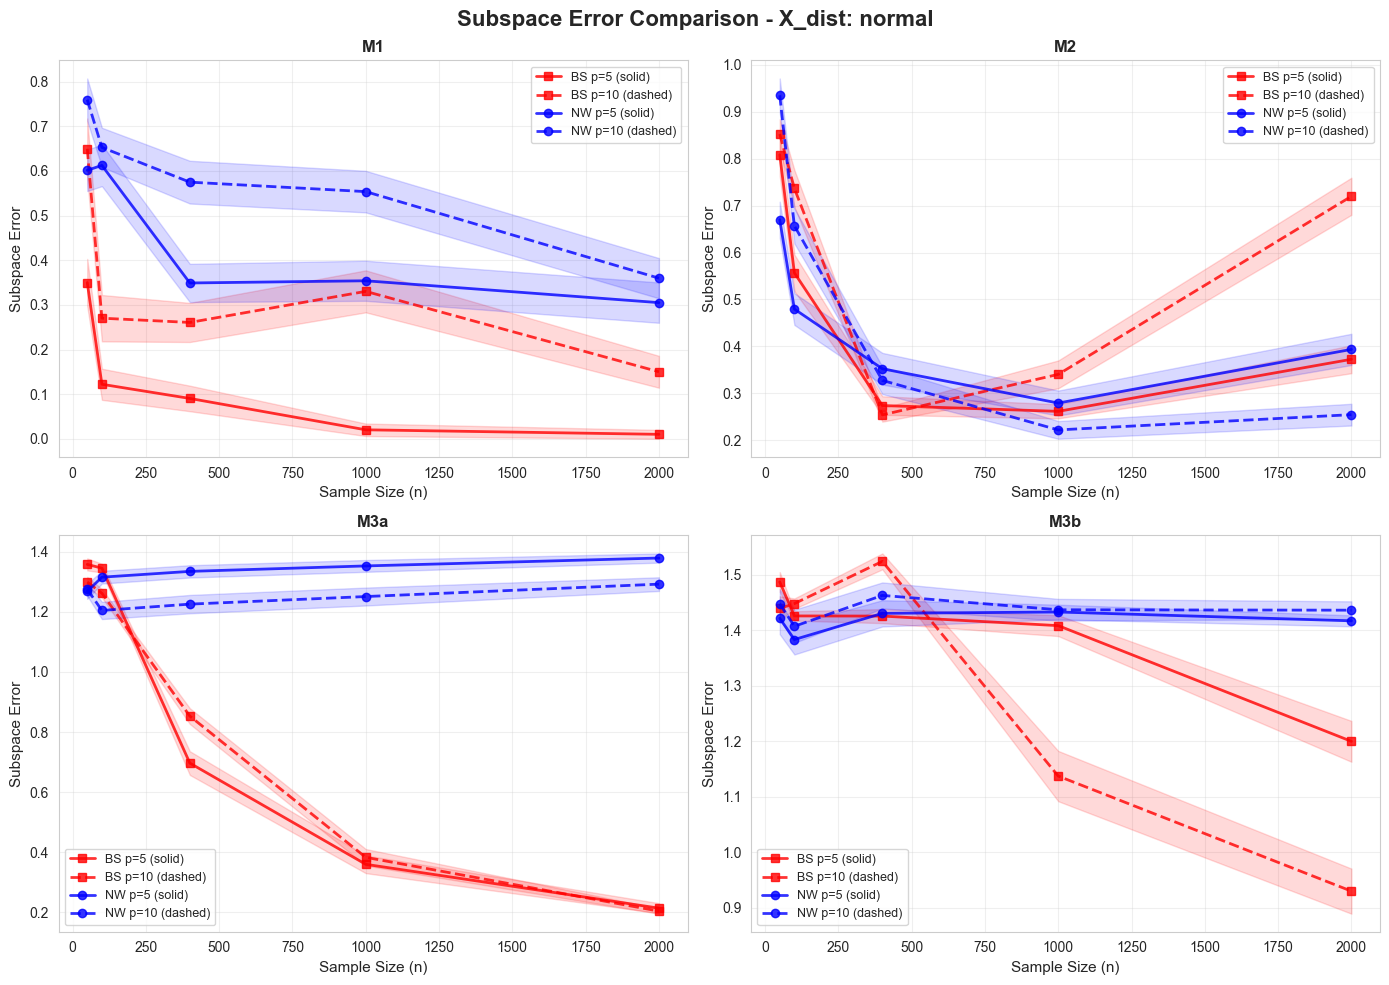

Saved: C:\Users\Spacecowboy\Downloads\subspace_error_all_comparison_uniform.png


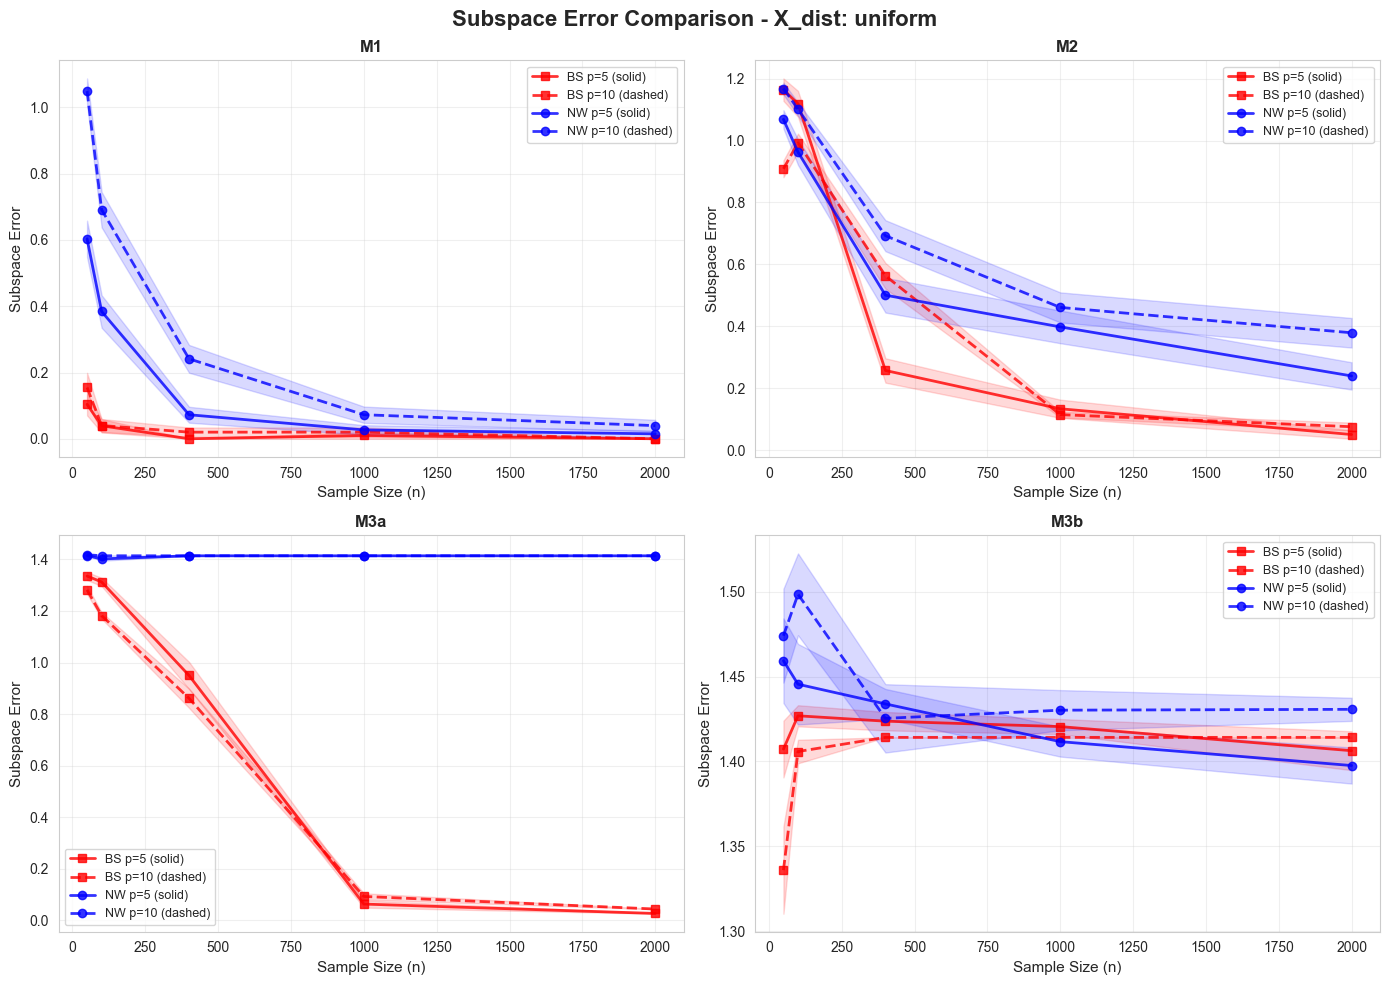


Plotting time_per_iter_all_mean...
Saved: C:\Users\Spacecowboy\Downloads\time_per_iter_all_comparison_normal.png


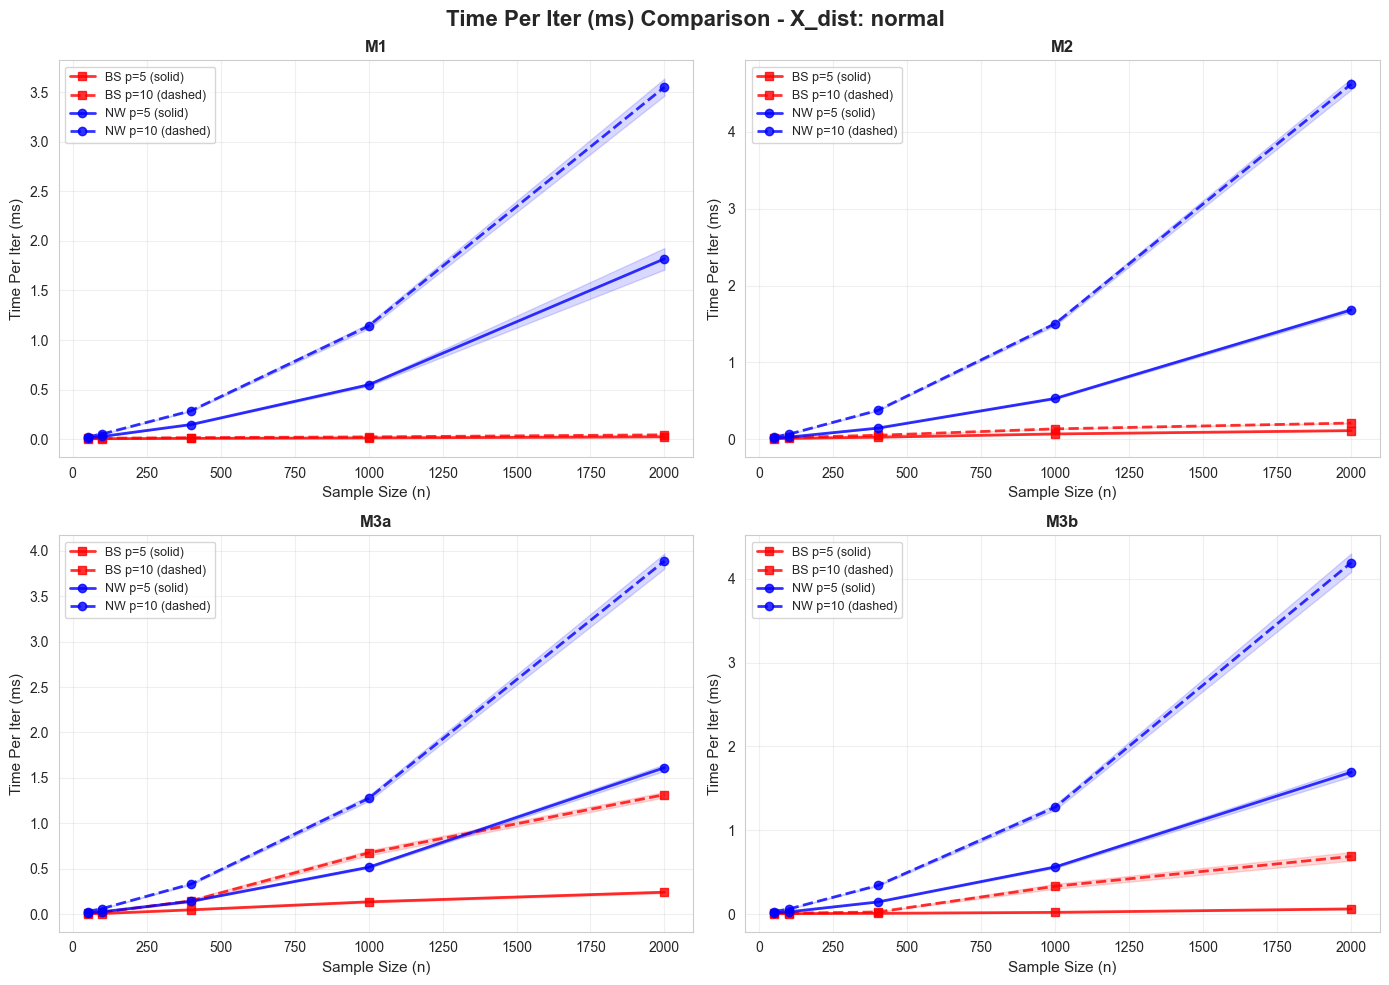

Saved: C:\Users\Spacecowboy\Downloads\time_per_iter_all_comparison_uniform.png


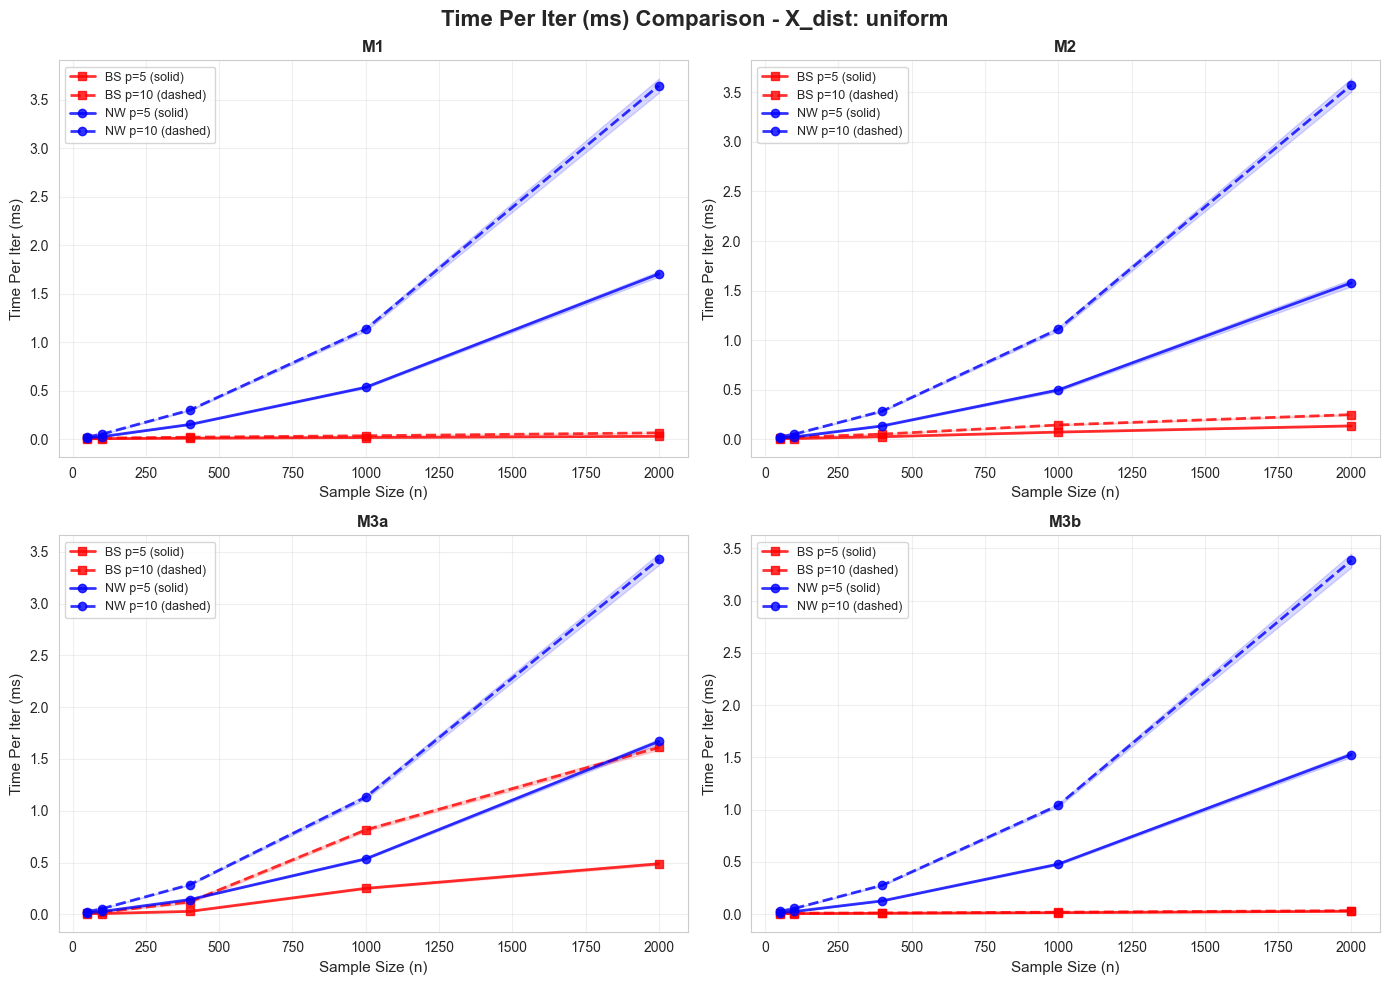


ANALYSIS COMPLETE!

Configuration used:
  Analysis mode: all
  Data mode: full_run
  Max sample size: 2000

All outputs saved to: C:\Users\Spacecowboy\Downloads

Created 2 × 3 = 6 plots
  (3 metrics × 2 X_dist values: normal, uniform)

Plot conventions:
  - Solid lines (─): p = 5
  - Dashed lines (--): p = 10
  - Blue: NW method
  - Red: BS method
  - Circles (○): NW
  - Squares (□): BS
  - Shaded regions: ± 1 standard deviation


In [ ]:
#!/usr/bin/env python3
"""
Analyze combined results comparing BS and NW methods

CONFIGURATION PARAMETERS:
- ANALYSIS_MODE: "all" (all repetitions) or "correct" (only correct dimension retrieval)
- DATA_MODE: "full_run" (all data) or "finished" (only n/X_dist/Model completed by both methods)
- MAX_SAMPLE_SIZE: None (all sample sizes) or integer (only include n <= this value)

Creates:
1. Dimension accuracy table with computational times (mean {std} format)
2. Separate plots for each X_dist (normal, uniform)
   Each plot combines p=5 (solid lines) and p=10 (dashed lines)


"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns



# ============================================================================
# ANALYSIS CONFIGURATION
# ============================================================================
# Choose which repetitions to analyze:
#   "all" - all repetitions (regardless of dimension accuracy)
#   "correct" - only repetitions where correct dimension was retrieved
ANALYSIS_MODE = "all"  # Options: "all" or "correct"

# Choose which data to include:
#   "full_run" - include all available data
#   "finished" - only include n/X_dist/Model combinations completed by BOTH methods
DATA_MODE = "full_run"  # Options: "full_run" or "finished"

# Set maximum sample size to include (None = include all sample sizes)
MAX_SAMPLE_SIZE = 2000  # Options: None or an integer (e.g., 500, 1000, 2000)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Load data
downloads_path = Path.home() / "Downloads"
file_path = downloads_path / "combined_results_all_combined.xlsx"

print(f"Loading data from {file_path}...")
df = pd.read_csv(file_path) if file_path.suffix == '.csv' else pd.read_excel(file_path)

print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")

# Rename "BS (hat)" to "BS" in the Method column
df['Method'] = df['Method'].replace('BS (hat)', 'BS')

# Filter for BS and NW methods
methods = ["BS", "NW"]
df_filtered = df[df['Method'].isin(methods)].copy()

print(f"\nFiltered to {len(df_filtered)} rows for methods: {methods}")

# The Model and X_dist columns already exist
print(f"\nUnique models: {sorted(df_filtered['Model'].unique())}")
print(f"Unique methods: {df_filtered['Method'].unique()}")
print(f"Unique X_dist: {df_filtered['X_dist'].unique()}")
print(f"Unique n values: {sorted(df_filtered['n'].unique())}")


# Check if p column exists
if 'p' in df_filtered.columns:
    print(f"Unique p values: {sorted(df_filtered['p'].unique())}")
    has_p = True
else:
    print("Note: No 'p' column found in data.")


# ============================================================================
# APPLY DATA_MODE FILTERING
# ============================================================================
print(f"\n{'='*80}")
print(f"CONFIGURATION")
print(f"{'='*80}")
print(f"Analysis mode: {ANALYSIS_MODE}")
print(f"Data mode: {DATA_MODE}")
print(f"Max sample size: {MAX_SAMPLE_SIZE if MAX_SAMPLE_SIZE is not None else 'All'}")

if DATA_MODE == "finished":
    print("\nFiltering to only include combinations finished by BOTH methods...")
    
    # Identify combinations that exist for both BS (hat) and NW
    if has_p:
        combinations = df_filtered.groupby(['Model', 'X_dist', 'n', 'p'])['Method'].apply(set).reset_index()
    else:
        combinations = df_filtered.groupby(['Model', 'X_dist', 'n'])['Method'].apply(set).reset_index()
    
    # Keep only combinations where both methods are present
    both_methods = combinations[combinations['Method'] == set(methods)]
    
    if has_p:
        finished_mask = df_filtered.set_index(['Model', 'X_dist', 'n', 'p']).index.isin(
            both_methods.set_index(['Model', 'X_dist', 'n', 'p']).index
        )
    else:
        finished_mask = df_filtered.set_index(['Model', 'X_dist', 'n']).index.isin(
            both_methods.set_index(['Model', 'X_dist', 'n']).index
        )
    
    before_count = len(df_filtered)
    df_filtered = df_filtered[finished_mask].copy()
    after_count = len(df_filtered)
    
    print(f"  Rows before filtering: {before_count}")
    print(f"  Rows after filtering: {after_count}")
    print(f"  Removed {before_count - after_count} rows from incomplete combinations")
    
    if after_count == 0:
        print("\nWARNING: No finished combinations found! Check your data.")
        print("Switching to 'full_run' mode...")
        DATA_MODE = "full_run"
else:
    print("\nUsing all available data (full_run mode)")

# Apply MAX_SAMPLE_SIZE filter
if MAX_SAMPLE_SIZE is not None:
    print(f"\nFiltering to only include sample sizes <= {MAX_SAMPLE_SIZE}...")
    before_count = len(df_filtered)
    df_filtered = df_filtered[df_filtered['n'] <= MAX_SAMPLE_SIZE].copy()
    after_count = len(df_filtered)
    
    print(f"  Rows before filtering: {before_count}")
    print(f"  Rows after filtering: {after_count}")
    print(f"  Removed {before_count - after_count} rows with n > {MAX_SAMPLE_SIZE}")
    
    if after_count == 0:
        print("\nWARNING: No data with n <= {MAX_SAMPLE_SIZE} found! Check your MAX_SAMPLE_SIZE setting.")
    else:
        remaining_n = sorted(df_filtered['n'].unique())
        print(f"  Remaining sample sizes: {remaining_n}")

# ============================================================================
# 1. DIMENSION ACCURACY TABLE
# ============================================================================

# Determine which time columns to use based on ANALYSIS_MODE
if ANALYSIS_MODE == "all":
    time_mean_col = 'time_all_mean'
    time_std_col = 'time_all_std'
else:  # "correct"
    time_mean_col = 'time_mean'
    time_std_col = 'time_std'

print("\n" + "="*80)
print("DIMENSION ACCURACY TABLE")
print("="*80)
print(f"Using time metric: {time_mean_col} (based on ANALYSIS_MODE={ANALYSIS_MODE})")

# Group by Model, Method, p, n and calculate accuracy and times
accuracy_results = []

# Determine unique p values
if has_p:
    p_values = sorted([p for p in df_filtered['p'].unique() if not pd.isna(p)])
    # Prefer p=5 and p=10 if they exist
    if 5 in p_values or 10 in p_values:
        p_values = [p for p in [5, 10] if p in p_values]
else:
    # If no p column, we'll just create one table without p distinction
    p_values = [None]

for model in sorted(df_filtered['Model'].unique()):
    for x_dist in sorted(df_filtered['X_dist'].unique()):
        for n in sorted(df_filtered['n'].unique()):
            row = {'Model': model, 'X_dist': x_dist, 'n': n}
            
            if has_p and len(p_values) > 1:
                for p in p_values:
                    for method in methods:
                        mask = (
                            (df_filtered['Model'] == model) & 
                            (df_filtered['X_dist'] == x_dist) &
                            (df_filtered['Method'] == method) & 
                            (df_filtered['p'] == p) & 
                            (df_filtered['n'] == n)
                        )
                        
                        if mask.sum() > 0:
                            # Use the existing dim_accuracy column and convert to percentage
                            accuracy = df_filtered[mask]['dim_accuracy'].mean() * 100
                            row[f"{method}_acc_p{p}"] = accuracy
                            
                            # Get time mean and std
                            time_mean = df_filtered[mask][time_mean_col].mean()
                            time_std = df_filtered[mask][time_std_col].mean()
                            row[f"{method}_time_mean_p{p}"] = time_mean
                            row[f"{method}_time_std_p{p}"] = time_std
                        else:
                            row[f"{method}_acc_p{p}"] = np.nan
                            row[f"{method}_time_mean_p{p}"] = np.nan
                            row[f"{method}_time_std_p{p}"] = np.nan
            else:
                # No p distinction
                for method in methods:
                    mask = (
                        (df_filtered['Model'] == model) & 
                        (df_filtered['X_dist'] == x_dist) &
                        (df_filtered['Method'] == method) & 
                        (df_filtered['n'] == n)
                    )
                    
                    if mask.sum() > 0:
                        accuracy = df_filtered[mask]['dim_accuracy'].mean() * 100
                        row[f"{method}_acc"] = accuracy
                        
                        time_mean = df_filtered[mask][time_mean_col].mean()
                        time_std = df_filtered[mask][time_std_col].mean()
                        row[f"{method}_time_mean"] = time_mean
                        row[f"{method}_time_std"] = time_std
                    else:
                        row[f"{method}_acc"] = np.nan
                        row[f"{method}_time_mean"] = np.nan
                        row[f"{method}_time_std"] = np.nan
            
            accuracy_results.append(row)

accuracy_df = pd.DataFrame(accuracy_results)

# Transform Model names for display
def transform_model_name(model):
    if 'func1' in model.lower():
        return 'M3a'
    elif 'func2' in model.lower():
        return 'M3b'
    else:
        return model

accuracy_df['Model'] = accuracy_df['Model'].apply(transform_model_name)

# Combine time mean and std into single columns with format "mean {std}"
if has_p and len(p_values) > 1:
    for p in p_values:
        for method in methods:
            time_mean_col = f"{method}_time_mean_p{p}"
            time_std_col = f"{method}_time_std_p{p}"
            time_combined_col = f"{method}_time_p{p}"
            
            if time_mean_col in accuracy_df.columns and time_std_col in accuracy_df.columns:
                # Create combined column with format "mean {std}"
                accuracy_df[time_combined_col] = accuracy_df.apply(
                    lambda row: f"{row[time_mean_col]:.1f} {{{row[time_std_col]:.1f}}}" 
                    if not pd.isna(row[time_mean_col]) else '',
                    axis=1
                )
                # Drop the individual columns
                accuracy_df = accuracy_df.drop(columns=[time_mean_col, time_std_col])
else:
    for method in methods:
        time_mean_col = f"{method}_time_mean"
        time_std_col = f"{method}_time_std"
        time_combined_col = f"{method}_time"
        
        if time_mean_col in accuracy_df.columns and time_std_col in accuracy_df.columns:
            accuracy_df[time_combined_col] = accuracy_df.apply(
                lambda row: f"{row[time_mean_col]:.1f} {{{row[time_std_col]:.1f}}}" 
                if not pd.isna(row[time_mean_col]) else '',
                axis=1
            )
            accuracy_df = accuracy_df.drop(columns=[time_mean_col, time_std_col])

# Rename columns for better display
if has_p and len(p_values) > 1:
    # Reorder columns: Model, X_dist, n, then alternating acc/time for each method and p
    base_cols = ['Model', 'X_dist', 'n']
    
    # Build column order and rename mapping
    new_cols = base_cols.copy()
    col_mapping = {'Model': 'Model', 'X_dist': 'Dist', 'n': 'n'}
    
    for p in p_values:
        # Add columns in order: BS acc, NW acc, BS time, NW time
        for method in ['BS', 'NW']:
            acc_col = f"{method}_acc_p{p}"
            
            new_cols.append(acc_col)
            col_mapping[acc_col] = f'{method} dim acc (%) p={p}'
        
        for method in ['BS', 'NW']:
            time_col = f"{method}_time_p{p}"
            
            new_cols.append(time_col)
            col_mapping[time_col] = f'{method} time (s) p={p}'
    
    # Reorder and rename
    accuracy_df = accuracy_df[new_cols]
    accuracy_df = accuracy_df.rename(columns=col_mapping)
else:
    base_cols = ['Model', 'X_dist', 'n']
    new_cols = base_cols.copy()
    col_mapping = {'Model': 'Model', 'X_dist': 'Dist', 'n': 'n'}
    
    # Add accuracy columns first, then time columns
    for method in ['BS', 'NW']:
        acc_col = f"{method}_acc"
        new_cols.append(acc_col)
        col_mapping[acc_col] = f'{method} dim acc (%)'
    
    for method in ['BS', 'NW']:
        time_col = f"{method}_time"
        new_cols.append(time_col)
        col_mapping[time_col] = f'{method} time (s)'
    
    accuracy_df = accuracy_df[new_cols]
    accuracy_df = accuracy_df.rename(columns=col_mapping)

print("\n", accuracy_df.to_string(index=False))

# Save to CSV
output_path = downloads_path / "dimension_accuracy_table.csv"
# Round accuracy columns to integers for saving (only numeric columns with 'dim acc' in name)
for col in accuracy_df.columns:
    if 'dim acc' in col and pd.api.types.is_numeric_dtype(accuracy_df[col]):
        accuracy_df[col] = accuracy_df[col].round(0).astype('Int64')  # Use Int64 to handle NaN

accuracy_df.to_csv(output_path, index=False)
print(f"\nSaved table to: {output_path}")

# ============================================================================
# 2. PLOTTING FUNCTIONS
# ============================================================================

def plot_metric(df, metric_mean, metric_std, x_dist, output_name):
    """
    Create a plot comparing BS and NW for a given metric and X_dist
    Combines p=5 (solid lines) and p=10 (dashed lines) in the same plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Add title based on metric
    base_metric = metric_mean.replace('_all_mean', '').replace('_mean', '').replace('_', ' ').title()
    
    # Add units for time metrics
    if 'time_per_iter' in metric_mean.lower():
        unit = ' (ms)'
    elif 'time' in metric_mean.lower():
        unit = ' (s)'
    else:
        unit = ''
    
    metric_label = base_metric + unit
    
    fig.suptitle(f'{metric_label} Comparison - X_dist: {x_dist}', fontsize=16, fontweight='bold')
    
    # Filter by X_dist
    df_dist = df[df['X_dist'] == x_dist].copy()
    
    models = sorted(df_dist['Model'].unique())
    
    # Create labels for models
    model_labels = []
    for m in models:
        if 'func1' in m.lower():
            model_labels.append('M3a')
        elif 'func2' in m.lower():
            model_labels.append('M3b')
        else:
            model_labels.append(m)
    
    # Ensure we have exactly 4 models, pad if necessary
    while len(models) < 4:
        models.append(None)
        model_labels.append(None)
    
    for idx, (model, label) in enumerate(zip(models[:4], model_labels[:4])):
        ax = axes[idx // 2, idx % 2]
        
        if model is None:
            ax.axis('off')
            continue
        
        # Plot for each method and p value
        for method in methods:
            color = 'blue' if method == 'NW' else 'red'
            marker = 'o' if method == 'NW' else 's'
            
            # Check if we have p values
            has_p_data = 'p' in df_dist.columns and df_dist['p'].notna().any()
            
            if has_p_data:
                # Plot both p=5 and p=10
                for p_val, linestyle, style_label in [(5, '-', 'solid'), (10, '--', 'dashed')]:
                    mask = (
                        (df_dist['Model'] == model) & 
                        (df_dist['Method'] == method) & 
                        (df_dist['p'] == p_val)
                    )
                    
                    if mask.sum() > 0:
                        data = df_dist[mask].groupby('n').agg({
                            metric_mean: 'mean',
                            metric_std: 'mean'
                        }).reset_index()
                        
                        data = data.sort_values('n')
                        
                        label_text = f"{method} p={p_val} ({style_label})"
                        
                        ax.plot(data['n'], data[metric_mean], 
                               marker=marker, label=label_text, color=color, 
                               linewidth=2, markersize=6, linestyle=linestyle, alpha=0.8)
                        
                        # Add error bands
                        ax.fill_between(
                            data['n'],
                            data[metric_mean] - data[metric_std],
                            data[metric_mean] + data[metric_std],
                            alpha=0.15, color=color
                        )
            else:
                # No p values, just plot the data
                mask = (
                    (df_dist['Model'] == model) & 
                    (df_dist['Method'] == method)
                )
                
                if mask.sum() > 0:
                    data = df_dist[mask].groupby('n').agg({
                        metric_mean: 'mean',
                        metric_std: 'mean'
                    }).reset_index()
                    
                    data = data.sort_values('n')
                    
                    ax.plot(data['n'], data[metric_mean], 
                           marker=marker, label=method, color=color, 
                           linewidth=2, markersize=6)
                    
                    # Add error bands
                    ax.fill_between(
                        data['n'],
                        data[metric_mean] - data[metric_std],
                        data[metric_mean] + data[metric_std],
                        alpha=0.2, color=color
                    )
        
        ax.set_xlabel('Sample Size (n)', fontsize=11)
        ax.set_ylabel(metric_label, fontsize=11)
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    output_file = downloads_path / f"{output_name}_{x_dist}.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_file}")
    plt.show()  # Display the plot
    plt.close()

# ============================================================================
# 3. CREATE ALL PLOTS
# ============================================================================

print("\n" + "="*80)
print("CREATING PLOTS")
print("="*80)

all_metrics = [
    ('time_mean', 'time_std', 'time_comparison'),
    ('time_all_mean', 'time_all_std', 'time_all_comparison'),
    ('subspace_error_mean', 'subspace_error_std', 'subspace_error_comparison'),
    ('subspace_error_all_mean', 'subspace_error_all_std', 'subspace_error_all_comparison'),
    ('time_per_iter_mean', 'time_per_iter_std', 'time_per_iter_comparison'),
    ('time_per_iter_all_mean', 'time_per_iter_all_std', 'time_per_iter_all_comparison'),
]

# Filter metrics based on ANALYSIS_MODE
if ANALYSIS_MODE == "all":
    metrics = [m for m in all_metrics if '_all_' in m[0]]
    print(f"Analysis mode: ALL - using metrics with '_all_' in name")
elif ANALYSIS_MODE == "correct":
    metrics = [m for m in all_metrics if '_all_' not in m[0]]
    print(f"Analysis mode: CORRECT - using metrics without '_all_' in name")
else:
    print(f"WARNING: Unknown ANALYSIS_MODE '{ANALYSIS_MODE}'. Using all metrics.")
    metrics = all_metrics

# Get unique X_dist values
x_dists = sorted(df_filtered['X_dist'].unique())
print(f"\nCreating plots for X_dist values: {x_dists}")

for metric_mean, metric_std, output_name in metrics:
    # Check if columns exist
    if metric_mean not in df_filtered.columns:
        print(f"Warning: Column '{metric_mean}' not found, skipping...")
        continue
    
    print(f"\nPlotting {metric_mean}...")
    
    # Create plots for each X_dist
    for x_dist in x_dists:
        plot_metric(df_filtered, metric_mean, metric_std, x_dist, output_name)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nConfiguration used:")
print(f"  Analysis mode: {ANALYSIS_MODE}")
print(f"  Data mode: {DATA_MODE}")
print(f"  Max sample size: {MAX_SAMPLE_SIZE if MAX_SAMPLE_SIZE is not None else 'All'}")
print(f"\nAll outputs saved to: {downloads_path}")
print(f"\nCreated {len(x_dists)} × {len(metrics)} = {len(x_dists) * len(metrics)} plots")
print(f"  ({len(metrics)} metrics × {len(x_dists)} X_dist values: {', '.join(x_dists)})")
print("\nPlot conventions:")
print("  - Solid lines (─): p = 5")
print("  - Dashed lines (--): p = 10")
print("  - Blue: NW method")
print("  - Red: BS method")
print("  - Circles (○): NW")
print("  - Squares (□): BS")
print("  - Shaded regions: ± 1 standard deviation")